# Tarefa 3: Explorando o Cap√≠tulo 6 ‚Äì "Deep Learning with PyTorch"

Este notebook explora conceitos fundamentais de otimiza√ß√£o em deep learning, baseando-se no Cap√≠tulo 6 do livro Deep Learning with PyTorch Step-by-Step. O foco ser√° em t√©cnicas e ferramentas essenciais para o treinamento de modelos neurais de forma mais est√°vel e eficiente. Os c√≥digos utilizados s√£o uma adapta√ß√£o do reposit√≥rio original dos livros que pode ser acessados [aqui](https://github.com/dvgodoy/PyTorchStepByStep)

# Bibliotecas utilizadas

In [121]:
# Importa√ß√µes para controle de aleatoriedade e c√≥pia profunda
import random
import numpy as np
from copy import deepcopy

# Importa√ß√µes para visualiza√ß√£o de dados
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Importa√ß√µes para manipula√ß√£o de imagens e dados
import pandas as pd
from PIL import Image

# Importa√ß√µes de bibliotecas Scikit-Learn para aprendizado de m√°quina
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Importa√ß√µes do PyTorch para deep learning
import torch
import torch.nn as nn  # M√≥dulos de redes neurais
import torch.nn.functional as F  # Opera√ß√µes funcionais (sem par√¢metros)
import torch.optim as optim  # Algoritmos de otimiza√ß√£o
from torch_lr_finder import LRFinder

# Utilit√°rios do PyTorch para manipula√ß√£o de datasets e loaders
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, TensorDataset
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
import torchvision.transforms as transforms

# Agendadores de taxa de aprendizado (learning rate schedulers)
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Utilit√°rios para download de arquivos e manipula√ß√£o de sistemas de arquivos
import requests
import zipfile
import os
import errno

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\elisa\AppData\Local\Temp\ipykernel_5092\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
from plots.chapter6 import *

# Classe Architecture

A classe Architecture foi criada pelo professor Ivanovitch no [reposit√≥rio](https://github.com/ivanovitchm/PPGEEC2318) da disciplina de Machine Learning para o Programa de P√≥s Gradua√ß√£o em Engenharia El√©trica e de Computa√ß√£o (PPGEEC) da UFRN. Ela √© insipirada na classe StepByStep, usada pelo Daniel Godoy.

A classe Architecture √© uma implementa√ß√£o modular e completa de uma pipeline de treinamento e valida√ß√£o de modelos no PyTorch. Durante o desenvolvimento do trabalho, v√°rios m√≥dulos ser√£o adicionados a ela.

In [4]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Aqui definimos os atributos da nossa classe.

        # Armazenamos os argumentos como atributos para uso posterior.
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Enviamos o modelo para o dispositivo especificado imediatamente.
        self.model.to(self.device)

        ## Esses atributos s√£o definidos aqui, 
        #mas como n√£o s√£o informados na cria√ß√£o da classe, permanecem como None.
        self.train_loader = None
        self.val_loader = None

        # Esses atributos ser√£o calculados internamente.
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Cria a fun√ß√£o de passo de treinamento para o modelo, a fun√ß√£o de perda e o otimizador.
        # Observa√ß√£o: n√£o h√° argumentos aqui! A fun√ß√£o utiliza diretamente os atributos da classe.
        self.train_step_fn = self._make_train_step_fn()
        # Cria a fun√ß√£o de passo de valida√ß√£o para o modelo e a fun√ß√£o de perda.
        self.val_step_fn = self._make_val_step_fn()

        # Para prop√≥sitos de hooks
        self.handles = {}
        self.visualization = {}

    def to(self, device):
    # Este m√©todo permite ao usu√°rio especificar um dispositivo diferente
    # Ele define o atributo correspondente (a ser usado depois nos mini-lotes)
    # e envia o modelo para o dispositivo especificado
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"N√£o foi poss√≠vel enviar para {device}, enviando para {self.device} em vez disso.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
    # Este m√©todo permite ao usu√°rio definir qual `train_loader` (e opcionalmente `val_loader`) usar
    # Ambos os carregadores s√£o atribu√≠dos como atributos da classe
    # para que possam ser referenciados posteriormente
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # Este m√©todo n√£o precisa de argumentos... Ele pode referir-se
        # aos atributos: self.model, self.loss_fn e self.optimizer
    
        # Cria uma fun√ß√£o que executa um passo no loop de treinamento
        def perform_train_step_fn(x, y):
            # Define o modelo no modo de TREINAMENTO
            self.model.train()
    
            # Passo 1 - Calcula a sa√≠da prevista do nosso modelo - forward pass
            yhat = self.model(x)
            # Passo 2 - Calcula a perda (loss)
            loss = self.loss_fn(yhat, y)
            # Passo 3 - Calcula os gradientes para os par√¢metros
            loss.backward()
            # Passo 4 - Atualiza os par√¢metros usando os gradientes e a taxa de aprendizado
            self.optimizer.step()
            self.optimizer.zero_grad()
    
            # Retorna a perda
            return loss.item()
    
        # Retorna a fun√ß√£o que ser√° chamada dentro do loop de treinamento
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Cria uma fun√ß√£o que executa um passo no loop de valida√ß√£o
        def perform_val_step_fn(x, y):
            # Define o modelo no modo de AVALIA√á√ÉO
            self.model.eval()
    
            # Passo 1 - Calcula a sa√≠da prevista do nosso modelo - forward pass
            yhat = self.model(x)
            # Passo 2 - Calcula a perda (loss)
            loss = self.loss_fn(yhat, y)
            # N√£o √© necess√°rio realizar os Passos 3 e 4, pois n√£o atualizamos par√¢metros durante a avalia√ß√£o
            return loss.item()
    
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # O mini-lote pode ser usado com ambos os carregadores
        # O argumento `validation` define qual carregador e fun√ß√£o
        # de passo correspondente ser√£o usados
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn
    
        if data_loader is None:
            return None
    
        # Uma vez definidos o carregador de dados e a fun√ß√£o de passo, este √© o mesmo
        # loop de mini-lotes que t√≠nhamos antes
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
    
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
    
        loss = np.mean(mini_batch_losses)
        return loss

    # esta fun√ß√£o foi atualizada nesta classe
    def set_seed(self, seed=42):
        # Define configura√ß√µes para garantir a reprodutibilidade
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # Para garantir a reprodutibilidade do processo de treinamento
        self.set_seed(seed)
    
        for epoch in range(n_epochs):
            # Mant√©m o controle do n√∫mero de √©pocas
            # atualizando o atributo correspondente
            self.total_epochs += 1
    
            # Loop interno
            # Realiza o treinamento usando mini-lotes
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
    
            # VALIDA√á√ÉO
            # sem gradientes na valida√ß√£o!
            with torch.no_grad():
                # Realiza a avalia√ß√£o usando mini-lotes
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Cria um dicion√°rio com todos os elementos para retomar o treinamento
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
    
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Carrega o dicion√°rio
        checkpoint = torch.load(filename)
    
        # Restaura o estado do modelo e do otimizador
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
    
        # Sempre usa o modo de TRAIN para retomar o treinamento
        self.model.train()

    def predict(self, x):
        # Define o modelo no modo de avalia√ß√£o para realizar previs√µes
        self.model.eval()
        # Converte uma entrada Numpy para um tensor float
        x_tensor = torch.as_tensor(x).float()
        # Envia a entrada para o dispositivo e usa o modelo para fazer a previs√£o
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Define de volta para o modo de treinamento
        self.model.train()
        # Desanexa o tensor, traz para a CPU e converte de volta para Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
        # Retorna a contagem de par√¢metros trein√°veis do modelo
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        # Plota as perdas de treinamento e valida√ß√£o ao longo das √©pocas
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Perda de Treinamento', c='b')
        plt.plot(self.val_losses, label='Perda de Valida√ß√£o', c='r')
        plt.yscale('log')
        plt.xlabel('√âpocas')
        plt.ylabel('Perda')
        plt.legend()
        plt.tight_layout()
        return fig
        
    def capture_gradients(self, layers_to_hook):
        # Captura os gradientes dos par√¢metros especificados
        if not isinstance(layers_to_hook, list):
            layers_to_hook = [layers_to_hook]
    
        modules = list(self.model.named_modules())
        self._gradients = {}
    
        def make_log_fn(name, parm_id):
            def log_fn(grad):
                # Armazena os gradientes na estrutura de dicion√°rio correspondente
                self._gradients[name][parm_id].append(grad.tolist())
                return None
            return log_fn
    
        for name, layer in self.model.named_modules():
            if name in layers_to_hook:
                self._gradients.update({name: {}})
                for parm_id, p in layer.named_parameters():
                    if p.requires_grad:
                        self._gradients[name].update({parm_id: []})
                        log_fn = make_log_fn(name, parm_id)
                        self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
        return
    

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # Visualiza tensores como imagens
        # O n√∫mero de imagens corresponde ao n√∫mero de subplots em uma linha
        n_images = len(axs)
        # Obt√©m os valores m√≠nimo e m√°ximo para escalar o grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # Para cada imagem
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Define o t√≠tulo, r√≥tulos e remove os ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nR√≥tulo: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPrevisto: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
            # Plota os pesos como uma imagem
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Obt√©m o objeto da camada do modelo
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # Apenas considera filtros de convolu√ß√µes 2D
            if isinstance(layer, nn.Conv2d):
                # Obt√©m as informa√ß√µes dos pesos
                weights = layer.weight.data.cpu().numpy()
                # weights -> (filtros (sa√≠da), canais (entrada), H, W)
                n_filters, n_channels, _, _ = weights.shape
    
                # Cria a figura
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels, figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # Para cada filtro (sa√≠da)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filtro #{i}',
                        title='Canal'
                    )
    
                for ax in axes.flat:
                    ax.label_outer()
    
                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Limpa quaisquer valores anteriores
        self.visualization = {}
        # Cria o dicion√°rio para mapear objetos de camada para seus nomes
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}
    
        if hook_fn is None:
            # Fun√ß√£o hook a ser anexada ao forward pass
            def hook_fn(layer, inputs, outputs):
                # Obt√©m o nome da camada
                name = layer_names[layer]
                # Desanexa os valores da sa√≠da
                values = outputs.detach().cpu().numpy()
                # Concatena os resultados se a fun√ß√£o hook for chamada m√∫ltiplas vezes
                # Exemplo: previs√µes em v√°rios mini-batches
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])
    
        for name, layer in modules:
            # Se a camada estiver na lista especificada
            if name in layers_to_hook:
                # Inicializa a chave correspondente no dicion√°rio
                self.visualization[name] = None
                # Registra o hook do forward e armazena o handle em outro dicion√°rio
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Percorre todos os hooks e os remove
        for handle in self.handles.values():
            handle.remove()
        # Limpa o dicion√°rio, j√° que todos os hooks foram removidos
        self.handles = {}
    
    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        # Filtra as camadas dispon√≠veis na visualiza√ß√£o
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1 for shape in shapes]
        total_rows = np.sum(n_rows)
    
        # Cria subplots com base no n√∫mero de imagens e camadas
        fig, axes = plt.subplots(total_rows, n_images,
                                 figsize=(1.5 * n_images, 1.5 * total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
        # Itera pelas camadas, com uma camada por linha de subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Obt√©m os mapas de caracter√≠sticas produzidos pela camada
            output = self.visualization[layer]
    
            is_vector = len(output.shape) == 2
    
            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] if is_vector else f'{layers[i]}\nfil#{row-start_row}',
                    title='Imagem' if (row == 0) else None
                )
                row += 1
    
        for ax in axes.flat:
            ax.label_outer()
    
        plt.tight_layout()
        return fig
    
    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()
    
        # Obt√©m o tamanho do batch e o n√∫mero de classes (1, se for bin√°rio)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # Para classifica√ß√£o multiclasse, a maior probabilidade vence
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # Para classifica√ß√£o bin√°ria, verifica se a √∫ltima camada √© sigmoid
            if isinstance(self.model, nn.Sequential) and isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()
    
        # Conta quantos exemplos foram classificados corretamente por classe
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)
    
    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        # Aplica uma fun√ß√£o para cada batch do loader
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)
    
        # Reduz os resultados (soma ou m√©dia)
        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)
    
        return results
    
    @staticmethod
    def statistics_per_channel(images, labels):
        # Obt√©m estat√≠sticas (m√©dia e desvio padr√£o) por canal
        n_samples, n_channels, n_height, n_weight = images.size()
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    
        means = flatten_per_channel.mean(axis=2)
        stds = flatten_per_channel.std(axis=2)
    
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        n_samples = torch.tensor([n_samples] * n_channels).float()
    
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)
    
    @staticmethod
    def make_normalizer(loader):
        # Cria normalizador baseado nas estat√≠sticas por canal
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)
    
    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Realiza o teste de intervalo de taxa de aprendizado
        previous_states = {'model': deepcopy(self.model.state_dict()), 'optimizer': deepcopy(self.optimizer.state_dict())}
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
    
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)
    
        tracking = {'loss': [], 'lr': []}
        iteration = 0
    
        while (iteration < num_iter):
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                yhat = self.model(x_batch)
                loss = self.loss_fn(yhat, y_batch)
                loss.backward()
    
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1 - alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)
    
                iteration += 1
                if iteration == num_iter:
                    break
    
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()
    
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])
    
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Taxa de Aprendizado')
        ax.set_ylabel('Perda')
        fig.tight_layout()
        return tracking, fig
    
    def set_optimizer(self, optimizer):
        # Define o otimizador
        self.optimizer = optimizer

# Importando os dados

Grande parte do cap√≠tulo 6 do livro utiliza o dataset [Rock Paper Scissors](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset), criado por Laurence Moroney. Pedra, Papel e Tesoura cont√©m imagens de diversas m√£os, de diferentes ra√ßas, idades e g√™neros, posicionadas nas formas de Pedra, Papel ou Tesoura e rotuladas de acordo. Moroney criou essas imagens utilizando t√©cnicas de CGI como um experimento para verificar se um modelo treinado em um conjunto de dados baseado em CGI poderia classificar imagens reais. Todas essas imagens possuem um fundo branco liso. Cada imagem tem dimens√µes de 300√ó300 pixels em cores de 24 bits.

In [7]:
def download_rps(localfolder=''):
    filenames = ['rps.zip', 'rps-test-set.zip']
    for filename in filenames:
        try:
            os.mkdir(f'{localfolder}{filename[:-4]}')

            localfile = f'{localfolder}{filename}'
            # url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/{}'
            # Updated from TFDS URL at
            # https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/rock_paper_scissors/rock_paper_scissors_dataset_builder.py
            url = 'https://storage.googleapis.com/download.tensorflow.org/data/{}'
            r = requests.get(url.format(filename), allow_redirects=True)
            open(localfile, 'wb').write(r.content)
            with zipfile.ZipFile(localfile, 'r') as zip_ref:
                zip_ref.extractall(localfolder)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
            else:
                print(f'{filename[:-4]} folder already exists!')
     

In [8]:
download_rps()

rps folder already exists!
rps-test-set folder already exists!


# Prepara√ß√£o dos dados

As imagens s√£o redimensionadas para 28x28 pixels utilizando a fun√ß√£o Resize do torchvision.transforms. Isso reduz as dimens√µes das imagens originais para o tamanho apropriado para modelos que trabalham com entradas de menor resolu√ß√£o.

A transforma√ß√£o ToTensor converte as imagens em tensores PyTorch e normaliza os valores dos pixels para estarem no intervalo de [0, 1] (a partir de valores originais entre [0, 255]).

As imagens s√£o automaticamente transformadas para o modelo de cor RGB pelo carregador de imagens do PIL (Pillow), o que significa que elas ter√£o tr√™s canais de cores (Red, Green, Blue). Nesse processo, o canal alfa (transpar√™ncia) das imagens originais √© perdido.

A classe ImageFolder organiza automaticamente as imagens no diret√≥rio rps em classes baseadas na estrutura de pastas. Cada subpasta em rps √© tratada como uma classe diferente, e todas as imagens dentro de cada subpasta s√£o atribu√≠das a essa classe.

In [9]:
# Transforma√ß√£o das imagens
temp_transform = Compose([Resize(28), ToTensor()])

# Cria√ß√£o do conjunto de dados
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

Vamos criar um DataLoader para o conjunto de dados temp_dataset com um tamanho de lote (batch_size) de 16 amostras por itera√ß√£o. O DataLoader facilita o carregamento de dados em mini-lotes para o treinamento de modelos, permitindo a itera√ß√£o eficiente sobre o conjunto de dados.

In [10]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

next(iter(temp_loader)) obt√©m o primeiro lote de imagens (first_images) e r√≥tulos (first_labels) do DataLoader criado anteriormente.

In [11]:
first_images, first_labels = next(iter(temp_loader))

A c√©lula abaixo calcula estat√≠sticas por canal, como a m√©dia e o desvio padr√£o, a partir das imagens e r√≥tulos extra√≠dos.
Essas estat√≠sticas podem ser √∫teis para normalizar os dados durante o pr√©-processamento.

In [12]:
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel) aplica a fun√ß√£o statistics_per_channel a cada mini-lote de dados no temp_loader.

A fun√ß√£o loader_apply percorre todo o DataLoader e calcula estat√≠sticas como m√©dia e desvio padr√£o por canal, acumulando os resultados.

In [13]:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

results armazena as estat√≠sticas calculadas e a c√©lula imprime esses valores, que incluem o n√∫mero de amostras, a m√©dia e o desvio padr√£o dos pixels por canal.

A fun√ß√£o Architecture.make_normalizer(temp_loader) calcula a m√©dia e o desvio padr√£o de cada canal (R, G, B ou outros canais) a partir de todo o conjunto de dados presente no temp_loader.

Utilizando as estat√≠sticas calculadas, a fun√ß√£o retorna uma inst√¢ncia da transforma√ß√£o Normalize do PyTorch, que padroniza os valores dos pixels

In [14]:
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

Vamos fazer a defini√ß√£o do pr√©-processamento das imagens

In [15]:
composer = Compose([
    Resize(28),  # Redimensiona as imagens para 28x28
    ToTensor(),  # Converte as imagens para tensores PyTorch
    Normalize(mean=[0.5], std=[0.5])  # Normaliza os valores de pixel
])

In [16]:
# Carregamento dos datasets de treinamento e valida√ß√£o
train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

In [17]:
# Cria√ß√£o dos DataLoaders para o treinamento e valida√ß√£o
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

O pr√≥ximo passo √© a defini√ß√£o de um modelo de dropout simples. O dropout ajuda na regulariza√ß√£o, removendo aleatoriamente conex√µes durante o treinamento. Aqui, testamos a diferen√ßa de comportamento entre modo de treinamento e valida√ß√£o

In [18]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [19]:
# Gera√ß√£o de pontos de teste
spaced_points = torch.linspace(0.1, 1.1, 11)
torch.manual_seed(44)

In [20]:
# Sa√≠da com dropout durante o treinamento
dropping_model.train()
output_train = dropping_model(spaced_points)
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

In [21]:
# Sa√≠da com dropout durante a valida√ß√£o
dropping_model.eval()
output_eval = dropping_model(spaced_points)
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [22]:
# An√°lise estat√≠stica do efeito do dropout
# Realizando m√∫ltiplas amostragens para demonstrar o impacto do dropout
p = 0.5
torch.manual_seed(17)
distrib_outputs = torch.tensor([
    F.linear(F.dropout(spaced_points, p=p), weight=torch.ones(11), bias=torch.tensor(0))
    for _ in range(1000)
])

In [23]:
# Defini√ß√£o de uma arquitetura de CNN customizada
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

        # Camadas totalmente conectadas (FC layers)
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)

        # Camada de dropout para regulariza√ß√£o
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Extra√ß√£o de caracter√≠sticas com camadas convolucionais
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Camadas totalmente conectadas com dropout
        if self.p > 0:
            x = self.drop(x)
        x = F.relu(self.fc1(x))
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [24]:
# Configura√ß√£o do modelo com dropout
torch.manual_seed(13)
model_cnn2 = CNN2(n_feature=5, p=0.3)

In [25]:
# Defini√ß√£o da fun√ß√£o de perda e otimizador
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

In [26]:
# Defini√ß√£o de um wrapper de arquitetura para facilitar o treino e valida√ß√£o
arch_cnn2 = Architecture(model_cnn2, multi_loss_fn, optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

In [27]:
# Avalia√ß√£o do modelo
Architecture.loader_apply(val_loader, arch_cnn2.correct)
Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0)

tensor([302, 372])

In [28]:
# Treinamento de um modelo id√™ntico sem dropout para comparar resultados
torch.manual_seed(13)
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(10)

# Taxa de aprendizagem (LR)

Na aprendizagem autom√°tica, a taxa de aprendizagem √© um hiperpar√¢metro crucial que determina o tamanho do passo em cada itera√ß√£o, enquanto se move em dire√ß√£o a um m√≠nimo da fun√ß√£o de perda. √â um conceito fundamental para treinar modelos de forma eficiente e eficaz, especialmente em algoritmos de otimiza√ß√£o como a descida de gradiente. 

Primeiro, precisamos definir os limites para o teste (start_lr e end_lr) e o n√∫mero de itera√ß√µes (num_iter) para mover de um valor ao outro. Al√©m disso, podemos escolher como fazer os incrementos: de forma linear ou exponencial. Vamos construir uma fun√ß√£o de ordem superior que receba todos esses argumentos e retorne outra fun√ß√£o, que devolve o fator multiplicador com base no n√∫mero atual de itera√ß√µes.

In [29]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

* start_lr: Taxa de aprendizagem inicial.
* end_lr: Taxa de aprendizagem final.
* num_iter: N√∫mero total de itera√ß√µes (ou √©pocas) para o ajuste da taxa de aprendizagem.
* step_mode: Modo de ajuste da taxa de aprendizagem (linear ou exp)

A fun√ß√£o retorna um scheduler (agendador) de taxa de aprendizagem.

In [31]:
# Configura√ß√£o inicial para a fun√ß√£o de taxa de aprendizado
start_lr = 0.01
end_lr = 0.1
num_iter = 10

In [32]:
# Fun√ß√£o para gerar a sequ√™ncia de taxas de aprendizado
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [33]:
# Configurando modelo, otimizador e agendador dummy
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [34]:
# Passos iniciais do otimizador e do agendador
dummy_optimizer.step()
dummy_scheduler.step()

In [35]:
# Configura√ß√£o para o teste de faixa de taxa de aprendizado
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

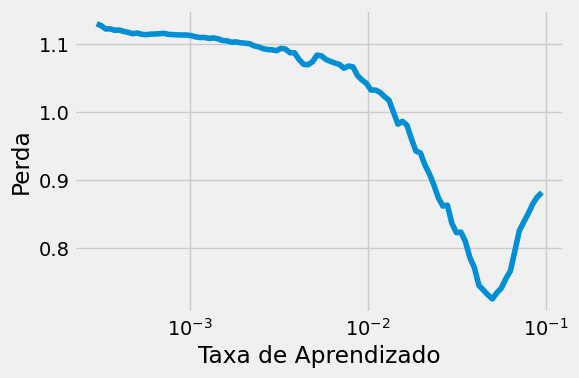

In [36]:
# Realizando o teste de faixa de taxa de aprendizado
arch_new = Architecture(new_model, multi_loss_fn, new_optimizer)
tracking, fig = arch_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [37]:
# Identificando a melhor taxa de aprendizado
min_loss = min(tracking['loss'])
min_loss_index = tracking['loss'].index(min_loss)
corresponding_lr = tracking['lr'][min_loss_index]

In [38]:
# Configurando novo otimizador e realizando treinamento
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
arch_new.set_optimizer(new_optimizer)
arch_new.set_loaders(train_loader, val_loader)
arch_new.train(10)

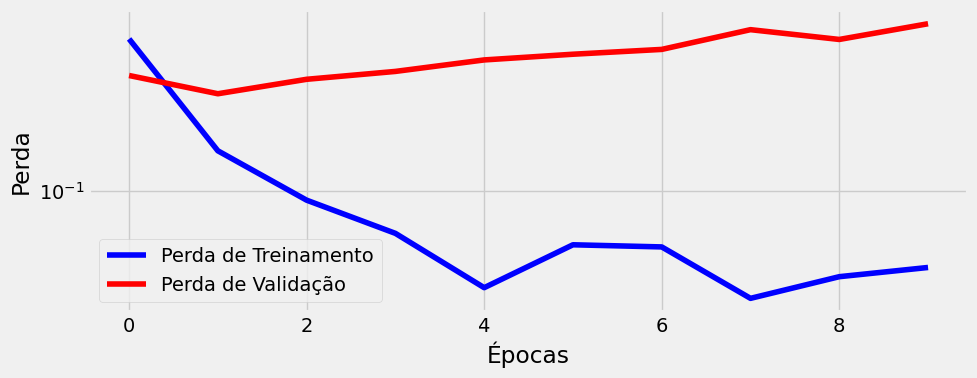

In [39]:
# Gerando gr√°fico de perdas
fig = arch_new.plot_losses()

Em vez de chamar uma fun√ß√£o diretamente, precisamos criar uma inst√¢ncia da classe LRFinder primeiro, usando os objetos t√≠picos de configura√ß√£o do modelo (modelo, otimizador, fun√ß√£o de perda e o dispositivo). Em seguida, podemos usar o m√©todo range_test(), fornecendo argumentos familiares: um data loader (carregador de dados), o limite superior para a taxa de aprendizagem e o n√∫mero de itera√ß√µes. O m√©todo reset() restaura os estados originais tanto do modelo quanto do otimizador.

In [40]:
# Configurando novamente o modelo para usar o LR Finder
torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [41]:
# Inicializando e rodando o LR Finder
lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:05<00:00, 16.73it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.17E-02


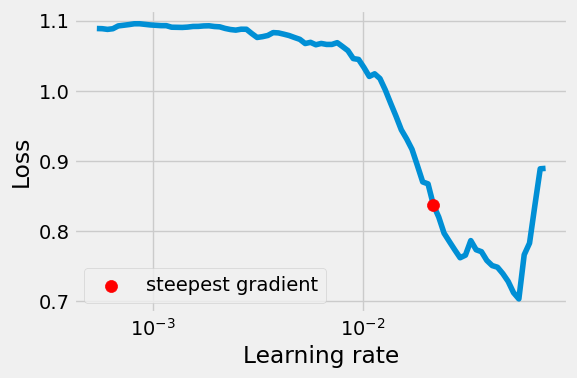

In [42]:
# Gerando o gr√°fico de taxa de aprendizado
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
lr_finder.plot(ax=ax, log_lr=True)
fig.tight_layout()
lr_finder.reset()

In [43]:
# Simula√ß√£o de custos para diferentes configura√ß√µes de aprendizado
epochs = list(range(30))
cost_eta_1 = [0.6 / (i + 1)**0.5 for i in epochs]
cost_eta_2 = [0.4 / (i + 1)**0.7 for i in epochs]
cost_eta_3 = [0.8 + 0.2 * (-1)**i for i in epochs]

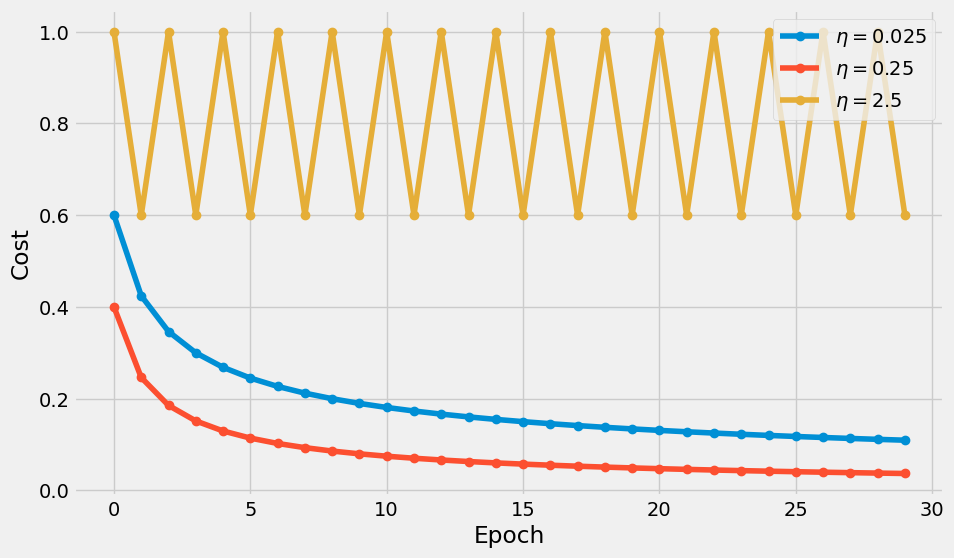

In [46]:
# Criando o gr√°fico de custo por √©poca
plt.figure(figsize=(10, 6))
plt.plot(epochs, cost_eta_1, 'o-', label=r'$\eta = 0.025$')
plt.plot(epochs, cost_eta_2, 'o-', label=r'$\eta = 0.25$')
plt.plot(epochs, cost_eta_3, 'o-', label=r'$\eta = 2.5$')

# Personalizando e exibindo o gr√°fico
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

# EWMA


Dentro das possibilidades do learning rate a gente tem o Adaptive Learning Rate (Taxa de aprendizagem adaptativa), que como o nome sugere, √© dinamicamente ajustada com base na performance e no gradiente da fun√ß√£o custo. 

Voc√™ j√° ouviu falar do otimizador Adam, certo? Ele √© um bom exemplo do Adaptive Learning Rate! ele come√ßa com a taxa de aprendizado fornecida como argumento, mas adapta essa taxa ao longo do treinamento, ajustando-a de forma diferente para cada par√¢metro do modelo. Ou mais ou menos isso, na verdade, o Adam n√£o adapta diretamente a taxa de aprendizado ‚Äî ele adapta os gradientes. Mas, como a atualiza√ß√£o dos par√¢metros √© feita pela multiplica√ß√£o da taxa de aprendizado e do gradiente, essa diferen√ßa se torna irrelevante na pr√°tica.

O Adam combina as caracter√≠sticas de dois outros otimizadores:

- **SGD com momentum:** Ele usa uma m√©dia m√≥vel dos gradientes em vez dos gradientes diretamente (isso √© conhecido como o **primeiro momento** em termos estat√≠sticos);
- **RMSProp:** Ele escala os gradientes usando uma m√©dia m√≥vel dos gradientes ao quadrado (o **segundo momento**, ou vari√¢ncia n√£o centralizada).

Complicou? Bom, vamos conhecer um pouco sobre essa m√©dia m√≥vel, ou melhor ainda, sobre a m√©dia m√≥vel exponencialmente ponderada, e depois a gente se aprofunda melhor no Adam.

De maneira bem simples, EWMA √© uma m√©dia m√≥vel exponencialmente ponderada, e como o nome sugere, ela √© diferente da m√©dia simples‚Ä¶ Ela fornece um peso maior para valores mais recentes, se destacando na suaviza√ß√£o dos dados. No Machine Learning, usamos o EWMA para suavizar os gradientes durante o treinamento. Pode parecer simples, mas impede que gradientes muito inst√°veis atrapalhem a converg√™ncia do modelo. Essa abordagem √© especialmente √∫til em algoritmos de otimiza√ß√£o como o Adam, que dependem de c√°lculos de m√©dias m√≥veis para ajustar a taxa de aprendizado de forma adaptativa.

Visualizar o comportamento dos gradientes suavizados com EWMA pode ajudar a entender melhor a estabilidade do treinamento e identificar poss√≠veis problemas, como gradientes explosivos ou o desaparecimento de gradientes.

Vamos entender o EWMA comparando com a m√©dia m√≥vel simples (MA). 

In [58]:
# Fun√ß√£o para calcular a m√©dia m√≥vel simples
def moving_average(data, N):
    """
    Calcula a m√©dia m√≥vel simples (MA) para uma lista de dados.

    Par√¢metros:
        data (list): Dados de entrada.
        N (int): N√∫mero de per√≠odos para calcular a m√©dia m√≥vel.

    Retorna:
        list: M√©dia m√≥vel calculada para os dados.
    """
    return [sum(data[i:i+N])/N for i in range(len(data)-N+1)]


A M√©dia M√≥vel Simples (MA) calcula a m√©dia aritm√©tica de um conjunto de valores ao longo de um per√≠odo fixo. Ela √© usada para suavizar flutua√ß√µes nos dados e destacar tend√™ncias.

In [59]:
# Fun√ß√£o para calcular a idade m√©dia de uma m√©dia m√≥vel
def average_age_ma(N):
    """
    Calcula a idade m√©dia da m√©dia m√≥vel (MA).

    Par√¢metros:
        N (int): N√∫mero de per√≠odos da m√©dia m√≥vel.

    Retorna:
        float: Idade m√©dia calculada.
    """
    return (N + 1) / 2

Por sua vez, a M√©dia M√≥vel Exponencialmente Ponderada (EWMA) atribui pesos exponenciais decrescentes aos valores passados, dando mais import√¢ncia aos valores mais recentes.

In [60]:
# Fun√ß√£o para visualizar a diferen√ßa entre EWMA e MA
def figure15(alpha=1/3, periods=5, steps=10):
    """
    Gera um gr√°fico comparando os pesos do EWMA e da MA.

    Par√¢metros:
        alpha (float): Fator de suaviza√ß√£o para EWMA.
        periods (int): N√∫mero de per√≠odos para MA.
        steps (int): N√∫mero de passos para visualiza√ß√£o.

    Retorna:
        matplotlib.figure.Figure: Figura gerada.
    """
    t = np.arange(1, steps+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(t-1, alpha*(1-alpha)**(t-1), label='EWMA')
    ax.bar(t-1, [1/periods]*periods + [0]*(10-periods), color='r', alpha=.3, label='MA')
    ax.set_xticks(t-1)
    ax.grid(False)
    ax.set_xlabel('Defasagem')
    ax.set_ylabel('Peso')
    ax.set_title('EWMA vs MA')
    ax.legend()
    fig.tight_layout()
    return fig


alpha √© um fator de suaviza√ß√£o, que varia entre 0 e 1 e controla a import√¢ncia dos valores mais recentes. 

Quando alpha est√° pr√≥ximo de 1: os valores mais recentes recebem mais peso, resultando em uma curva mais sens√≠vel a mudan√ßas. Quando alpha est√° pr√≥ximo de 0: os valores antigos ainda influenciam bastante, resultando em uma curva mais suave e lenta para reagir a mudan√ßas.

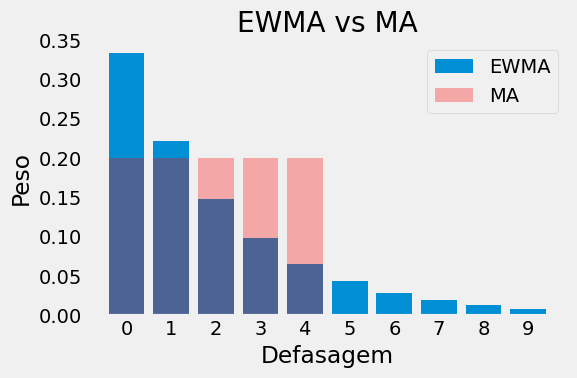

In [61]:
# Visualiza√ß√£o da diferen√ßa entre EWMA e MA
fig = figure15()

O gr√°fico compara a M√©dia M√≥vel Exponencialmente Ponderada (EWMA) e a M√©dia M√≥vel Simples (MA) usando 5 per√≠odos. O eixo Y diz respeito ao peso atribuido a cada ponto de dado anterior ao calcular a m√©dia, enquanto o eixo X representa o n√∫mero de passos (ou per√≠odos) anterires ao ponto atual (quanto maior o lag, mas distante no passado est√° o dado).

Pela imagem a gente analisa o seguinte: a EWMA atribui pesos decrescentes exponencialmente ao longo do tempo. Os valores mais recentes t√™m mais influ√™ncia no c√°lculo da m√©dia, enquanto os valores mais antigos t√™m menos peso. Isso quer dizer que a EWMA reage mais rapidamente a mudan√ßas recentes nos dados, pois d√° mais peso ao ponto atual.

J√° a MA, atribui pesos iguais para os √∫ltimos 5 per√≠odos. Assim, os √∫ltimos 5 pontos contribuem igualmente para o c√°lculo da m√©dia, enquanto os mais antigos n√£o t√™m influ√™ncia. Ou seja, quando comparado a EWMA, A MA reage mais lentamente e suaviza os dados de forma mais uniforme, sem priorizar os valores recentes.

Essa diferen√ßa √© importante no contexto de otimiza√ß√£o de redes neurais, pois a EWMA ajuda a estabilizar o treinamento ao suavizar os gradientes de forma mais din√¢mica.

In [62]:
# Fun√ß√£o para calcular o EWMA
def EWMA(past_value, current_value, alpha):
    """
    Calcula o EWMA para um dado ponto.

    Par√¢metros:
        past_value (float): Valor anterior.
        current_value (float): Valor atual.
        alpha (float): Fator de suaviza√ß√£o.

    Retorna:
        float: Valor suavizado.
    """
    return (1 - alpha) * past_value + alpha * current_value

In [63]:
# Fun√ß√£o para calcular a s√©rie EWMA
def calc_ewma(values, period):
    """
    Calcula a s√©rie de EWMA para uma lista de valores.

    Par√¢metros:
        values (list): Dados de entrada.
        period (int): Per√≠odo para calcular o EWMA.

    Retorna:
        numpy.array: S√©rie suavizada com EWMA.
    """
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

O Bias-Corrected EWMA (M√©dia M√≥vel Exponencialmente Ponderada Corrigida para Vi√©s) √© uma varia√ß√£o da EWMA que corrige o vi√©s introduzido no in√≠cio do c√°lculo de uma m√©dia m√≥vel exponencialmente ponderada.

Quando o c√°lculo de uma EWMA come√ßa, os primeiros valores podem estar enviesados para valores menores, pois a s√©rie temporal ainda n√£o acumulou informa√ß√µes suficientes. Isso ocorre porque o c√°lculo depende fortemente dos valores iniciais e a m√©dia tende a subestimar os valores reais no in√≠cio. Para corrigir esse vi√©s, multiplicamos o termo da EWMA por um fator de corre√ß√£o de vi√©s.  Essa corre√ß√£o √© especialmente usada em algoritmos como o Adam, para melhorar a estabilidade no in√≠cio do treinamento, j√° que o otimizador utiliza EWMA tanto para os gradientes quanto para os gradientes ao quadrado.

In [64]:
# Fun√ß√£o para corrigir o vi√©s do EWMA
def correction(averaged_value, beta, steps):
    """
    Corrige o vi√©s do EWMA.

    Par√¢metros:
        averaged_value (float): Valor suavizado.
        beta (float): Fator de decaimento.
        steps (int): N√∫mero de passos.

    Retorna:
        float: Valor corrigido.
    """
    return averaged_value / (1 - (beta ** steps))

In [65]:
# Fun√ß√£o para calcular o EWMA corrigido
def calc_corrected_ewma(values, period):
    """
    Calcula a s√©rie de EWMA corrigida.

    Par√¢metros:
        values (list): Dados de entrada.
        period (int): Per√≠odo para calcular o EWMA.

    Retorna:
        numpy.array: S√©rie suavizada e corrigida com EWMA.
    """
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

In [66]:
# Fun√ß√£o para comparar MA e EWMA
def ma_vs_ewma(values, periods=19):
    """
    Gera um gr√°fico comparando MA, EWMA e EWMA corrigido.

    Par√¢metros:
        values (list): Dados de entrada.
        periods (int): N√∫mero de per√≠odos para calcular a MA.

    Retorna:
        matplotlib.figure.Figure: Figura gerada.
    """
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(values, c='k', label='Temperaturas')
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA)')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='EWMA Corrigido')
    ax.set_title('MA vs EWMA')
    ax.set_ylabel('Temperatura')
    ax.set_xlabel('Dias')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

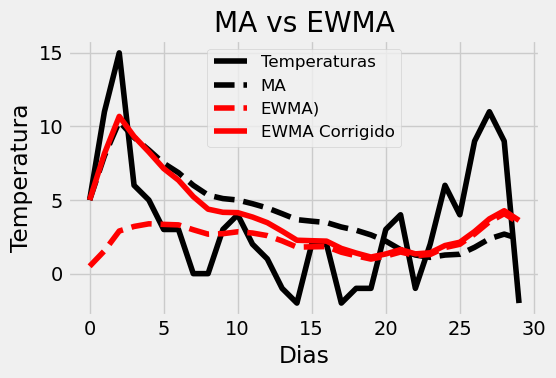

In [67]:
# Dados de temperatura e visualiza√ß√£o do gr√°fico
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1,
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])
fig = ma_vs_ewma(temperatures, periods=19)

A Figura acima mostra um exemplo pr√°tico da compara√ß√£o da M√©dia M√≥vel Simples (MA), da EWMA e a EWMA com corre√ß√£o do vi√©s (Bias). Como esperado, a EWMA sem corre√ß√£o (linha vermelha tracejada) est√° bem distante no in√≠cio, enquanto a m√©dia m√≥vel regular (linha preta tracejada) acompanha os valores reais de forma muito mais pr√≥xima. No entanto, a EWMA corrigida faz um √≥timo trabalho ao acompanhar os valores reais desde o in√≠cio. De fato, ap√≥s 19 dias, as duas EWMAs s√£o quase indistingu√≠veis.

# Adam 

J√° sabemos que o otimizador Adam utiliza a m√©dia m√≥vel exponencialmente ponderada (EWMA) para ajustar os gradientes durante o treinamento, vamos dar uma olhada em como isso acontece.

Para cada par√¢metro do modelo, o Adam calcula **duas EWMA**:

1. **EWMA dos gradientes**  ‚Äì para suavizar os gradientes.
2. **EWMA do quadrado dos gradientes** ‚Äì para escalonar os gradientes e controlar a vari√¢ncia.

Essas m√©dias s√£o corrigidas para vi√©s no in√≠cio do trei.namentoa).

Vamos falar de seis argumentos para o Adam no PyTorch, a maioria j√° mencionado por aqui.

- Primeiro o `params` , que s√£o os par√¢metros do modelo que o otimizador ir√° atualizar durante o treinamento.  Normalmente, √© passado como `model.parameters()` ao inicializar o otimizador.
- o `lr`(learning rate), a  taxa de aprendizado, que controla o tamanho dos passos na dire√ß√£o do gradiente durante a atualiza√ß√£o dos par√¢metros. 
Valor padr√£o: `1e-3` (0.001).
- `betas`, uma tupla contendo os valores `beta1` e `beta2`, usados para calcular as EWMAs dos gradientes e dos gradientes ao quadrado.
    - Valores padr√£o: `(0.9, 0.999)`
        - `beta1`: controla a suaviza√ß√£o dos gradientes.
        - `beta2`: controla a suaviza√ß√£o dos gradientes ao quadrado (para a escala).
- **`eps`(epsilon), u**m pequeno valor constante (normalmente `1e-8`) adicionado ao denominador para evitar divis√£o por zero e garantir estabilidade num√©rica.

Esses quatro argumentos s√£o os principais para o funcionamento b√°sico do Adam, enquanto `weight_decay` e `amsgrad` s√£o argumentos opcionais que controlam regulariza√ß√£o e varia√ß√µes do algoritmo.

- `weight_decay`  vai adicionar uma regulariza√ß√£o L2 para prevenir overfitting, reduzindo o valor dos pesos ao longo do tempo.
- `amsgrad` √© uma variante do Adam que ajusta a forma de calcular o gradiente adaptado para maior estabilidade.

Esses ajustes tornam o Adam mais robusto e controlado, especialmente em treinamentos de redes neurais profundas.

In [78]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

# Visualizing Adapted Gradients


A partir de agora, e at√© o final da se√ß√£o "Learning Rates", usaremos APENAS o conjunto de dados de regress√£o linear simples para ilustrar os efeitos de diferentes par√¢metros na minimiza√ß√£o da perda. Voltaremos ao conjunto de dados "Rock Paper Scissors" na se√ß√£o "Putting It All Together".

Primeiro, geramos novamente os pontos de dados e executamos a etapa t√≠pica de prepara√ß√£o dos dados (constru√ß√£o do conjunto de dados, divis√£o e cria√ß√£o de data loaders):

In [69]:
# Configura√ß√µes iniciais
true_b = 1  # Intercepto verdadeiro
true_w = 2  # Coeficiente angular verdadeiro
N = 100  # N√∫mero de amostras

In [70]:
# Gerar dados sint√©ticos
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (0.1 * np.random.randn(N, 1))

In [71]:
idx = np.arange(N)
np.random.shuffle(idx)

In [72]:
# Dividir os √≠ndices em conjunto de treino e valida√ß√£o
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]

In [73]:
# Separar os dados de treino e valida√ß√£o
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Vamos ilustrar os efeitos de diferentes par√¢metros na minimiza√ß√£o da perda! Primeiro precisamos fazer o tratamento usual dos dados: constru√ß√£o do dataset, divis√£o e cria√ß√£o de data loaders).

In [74]:
# Configura√ß√µes do PyTorch
torch.manual_seed(13)
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

In [75]:
# Criar dataset com todos os pontos de dados
dataset = TensorDataset(x_tensor, y_tensor)

In [76]:
# Dividir o dataset
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])

In [77]:
# Criar DataLoaders para treino e valida√ß√£o
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Depois, revisamos a configura√ß√£o do modelo e alteramos o otimizador de SGD para Adam:

In [78]:
# Criar o modelo de regress√£o linear
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

Estar√≠amos prontos para usar a classe Architecture para treinar nosso modelo, se n√£o fosse por um pequeno detalhe: ainda n√£o temos uma maneira de registrar os gradientes. Ent√£o, vamos resolver isso adicionando mais um m√©todo √† nossa classe: capture_gradients(). Assim como o m√©todo attach_hooks(), ele receber√° uma lista de camadas que devem ser monitoradas quanto aos valores dos seus gradientes.

In [79]:
# Arquitetura de treinamento
sbs_adam = Architecture(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader)

In [80]:
# Fun√ß√£o para capturar gradientes
def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    self._gradients = {}

    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return None
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return
setattr(Architecture, 'capture_gradients', capture_gradients)

Para cada camada monitorada, a fun√ß√£o percorre os par√¢metros e, para aqueles que requerem gradientes, criar√° uma fun√ß√£o de registro (log_fn()) e registrar√° um gancho (hook) para ela no tensor correspondente ao par√¢metro.

A fun√ß√£o de registro simplesmente adiciona os gradientes a uma lista na entrada do dicion√°rio correspondente ao nome da camada e do par√¢metro. O pr√≥prio dicion√°rio, _gradients, √© um atributo da classe (que ser√° criado dentro do m√©todo construtor, mas estamos configurando manualmente usando setattr por enquanto). 

Ao final do treinamento, teremos coletado duas s√©ries de 50 gradientes cada (cada √©poca possui cinco mini-lotes), cada s√©rie correspondendo a um par√¢metro da camada linear (peso e vi√©s), ambos armazenados no atributo _gradients da nossa classe Architecture .

Agora que tal comparar com o SGD? Temos discutido como a atualiza√ß√£o do par√¢metro √© diferente, mas agora √© hora de mostrar como isso afeta o treinamento do modelo. Vamos visualizar o caminho percorrido por cada otimizador para trazer os dois par√¢metros (mais pr√≥ximos) de seus valores √≥timos. Vamos criar um outro m√©todo para isso.

O novo m√©todo, chamado de capture_parameters(), funciona de forma semelhante ao capture_gradients(). Ele mant√©m um dicion√°rio (parameters) como atributo da classe e registra hooks para as camadas cujos par√¢metros gostar√≠amos de registrar. A fun√ß√£o de registro simplesmente percorre os par√¢metros de uma camada e adiciona seus valores √† entrada correspondente no dicion√°rio.

In [81]:
# Fun√ß√£o para capturar par√¢metros
def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    self._parameters = {}

    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return
setattr(Architecture, 'capture_parameters', capture_parameters)

Vamos criar duas inst√¢ncias de Architecture, cada uma usando um otimizador diferente, configur√°-las para capturar par√¢metros e trein√°-las por dez √©pocas. Os par√¢metros capturados (vi√©s e peso) desenhar√£o os seguintes caminhos (o ponto vermelho representa seus valores √≥timos).

In [82]:
# Treinar o modelo e capturar gradientes
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

In [83]:
# Processar os gradientes
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

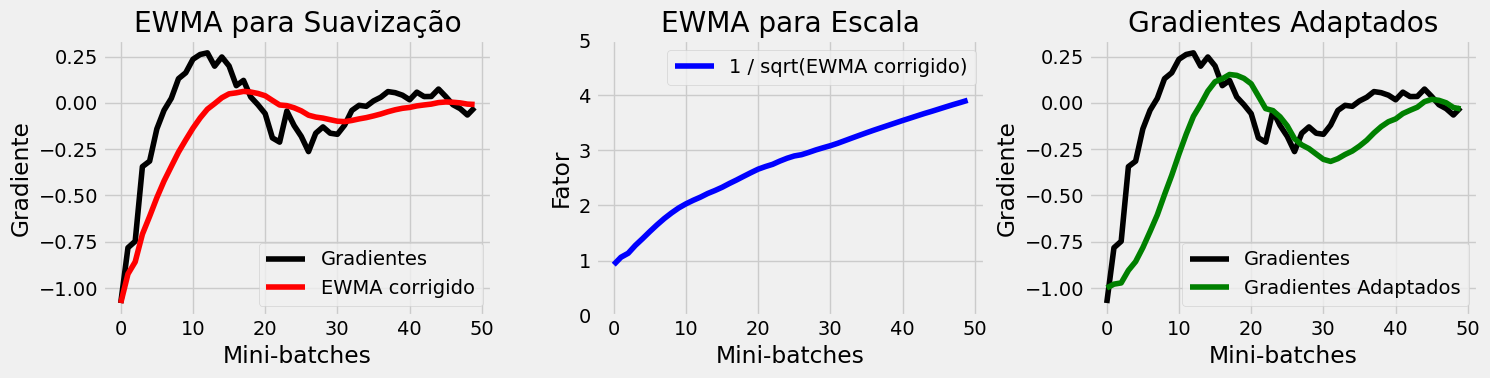

In [84]:
# Fun√ß√£o para visualiza√ß√£o dos gradientes
def figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # EWMA para suaviza√ß√£o
    axes[0].plot(gradients, label='Gradientes', color='black')
    axes[0].plot(corrected_gradients, label='EWMA corrigido', color='red')
    axes[0].set_title('EWMA para Suaviza√ß√£o')
    axes[0].set_xlabel('Mini-batches')
    axes[0].set_ylabel('Gradiente')
    axes[0].legend()

    # EWMA para escala
    axes[1].plot((1/np.sqrt(corrected_sq_gradients)), color='blue', label='1 / sqrt(EWMA corrigido)')
    axes[1].set_title('EWMA para Escala')
    axes[1].set_xlabel('Mini-batches')
    axes[1].set_ylabel('Fator')
    axes[1].legend()
    axes[1].set_ylim([0, 5])

    # Gradientes adaptados
    axes[2].plot(gradients, label='Gradientes', color='black')
    axes[2].plot(adapted_gradients, label='Gradientes Adaptados', color='green')
    axes[2].set_title('Gradientes Adaptados')
    axes[2].set_xlabel('Mini-batches')
    axes[2].set_ylabel('Gradiente')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    return fig

# Exibir o gr√°fico
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

No gr√°fico √† esquerda, vemos que o EWMA corrigido por vi√©s dos gradientes (em vermelho) suaviza os gradientes. No centro, o EWMA corrigido por vi√©s dos gradientes ao quadrado √© usado para escalar os gradientes suavizados. √Ä direita, ambos os EWMAs s√£o combinados para calcular os gradientes adaptados.

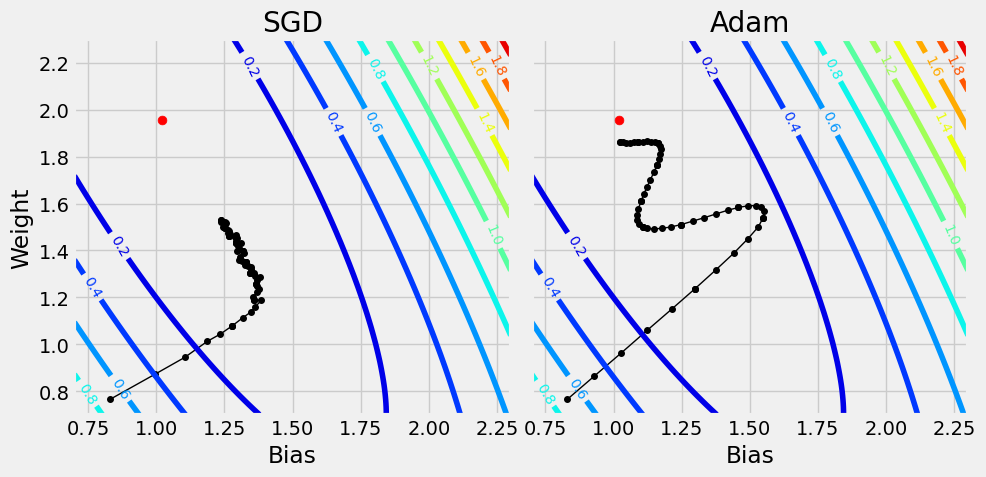

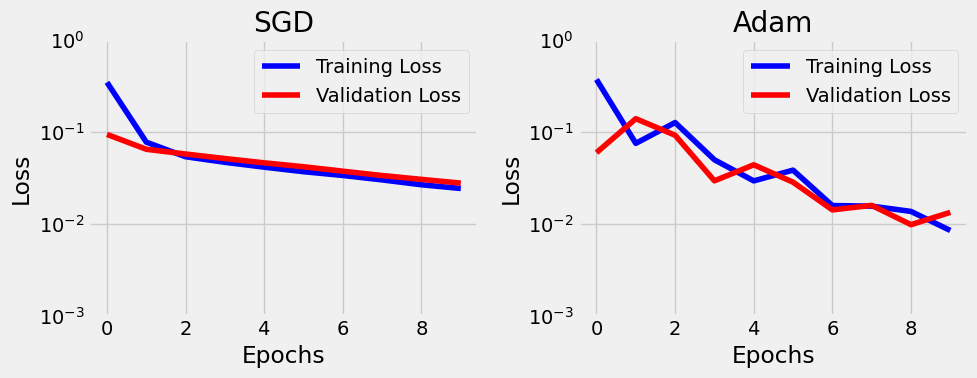

In [85]:
# Compara√ß√£o de otimizadores
def compare_and_visualize_optimizers():
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')

    optimizers = {
        'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
        'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}
    }

    results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)
    b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)

    fig_paths = plot_paths(results, b, w, bs, ws, all_losses)
    fig_losses = plot_losses(results)
    return fig_paths, fig_losses

fig_paths, fig_losses = compare_and_visualize_optimizers()

# Stochastic Gradient Descent (SGD)

√â um algoritmo de otimiza√ß√£o que atualiza os pesos de um modelo utilizando uma amostra aleat√≥ria dos dados de treinamento.  O SGD do PyTorch tem alguns argumentos:

- **params**: par√¢metros do modelo
- **lr**: taxa de aprendizado
- **weight_decay**: penalidade L2
- **momentum**: fator de momentum, o pr√≥prio argumento beta do SGD.
- **dampening**: fator de amortecimento para o momentum
- **nesterov**: habilita o momentum de Nesterov, que √© uma vers√£o mais inteligente do momentum regular.

In [90]:
# Configurando a semente para reprodutibilidade
torch.manual_seed(42)

# Definindo o modelo sequencial com uma camada linear
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))  # Camada com 1 entrada e 1 sa√≠da

# Definindo a fun√ß√£o de perda como o erro m√©dio quadr√°tico (MSE)
loss_fn = nn.MSELoss(reduction='mean')

In [91]:
# Configurando os otimizadores para compara√ß√£o
# Inclui SGD puro, SGD com Momentum e SGD com Nesterov Momentum
optimizers = {
    'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},  # Gradiente Descendente Simples
    'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},  # Com Momentum
    'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}  # Nesterov Momentum
}

In [92]:
# Comparando os otimizadores com os dados de treinamento e valida√ß√£o
# n_epochs define o n√∫mero de √©pocas para treinamento
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

# Gerando os dados de contorno para visualiza√ß√£o do espa√ßo de perda
b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)


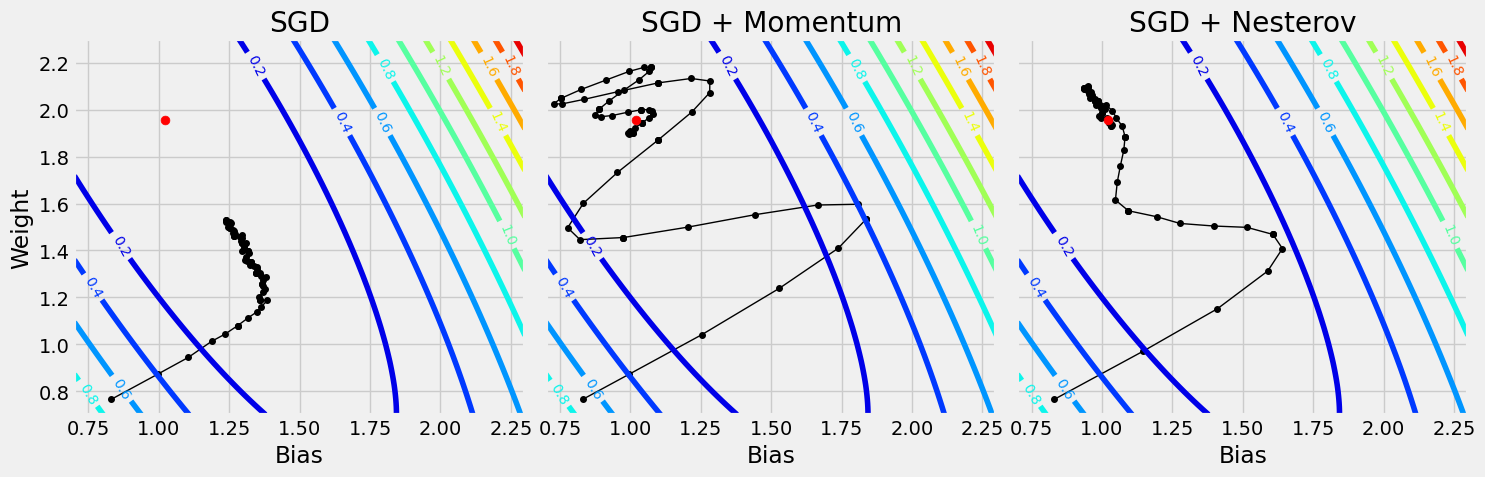

In [93]:
# Gerando o gr√°fico de trajet√≥rias no espa√ßo de par√¢metros (bias e peso)
fig_paths = plot_paths(results, b, w, bs, ws, all_losses)

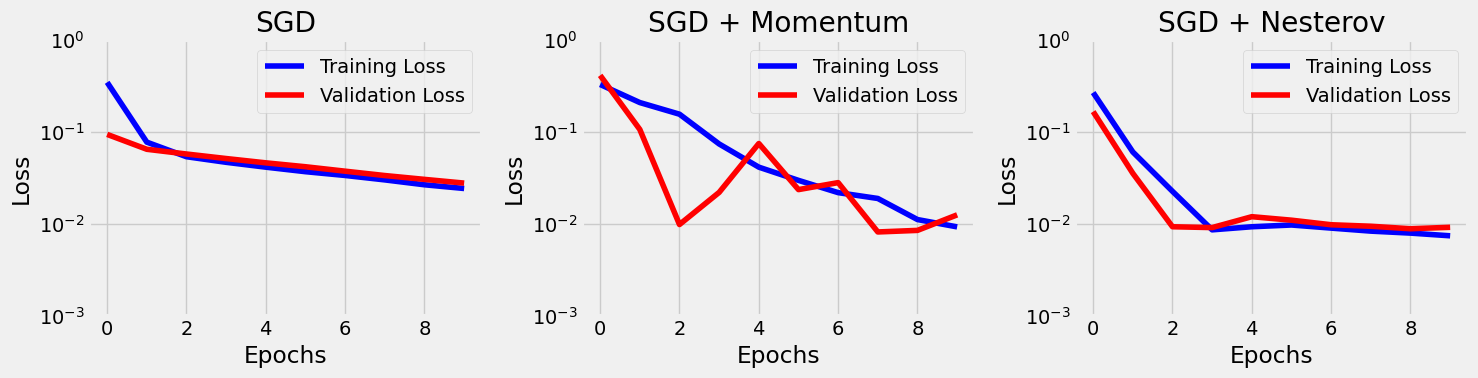

In [94]:
# Visualizando os resultados dos otimizadores
fig_losses = plot_losses(results)

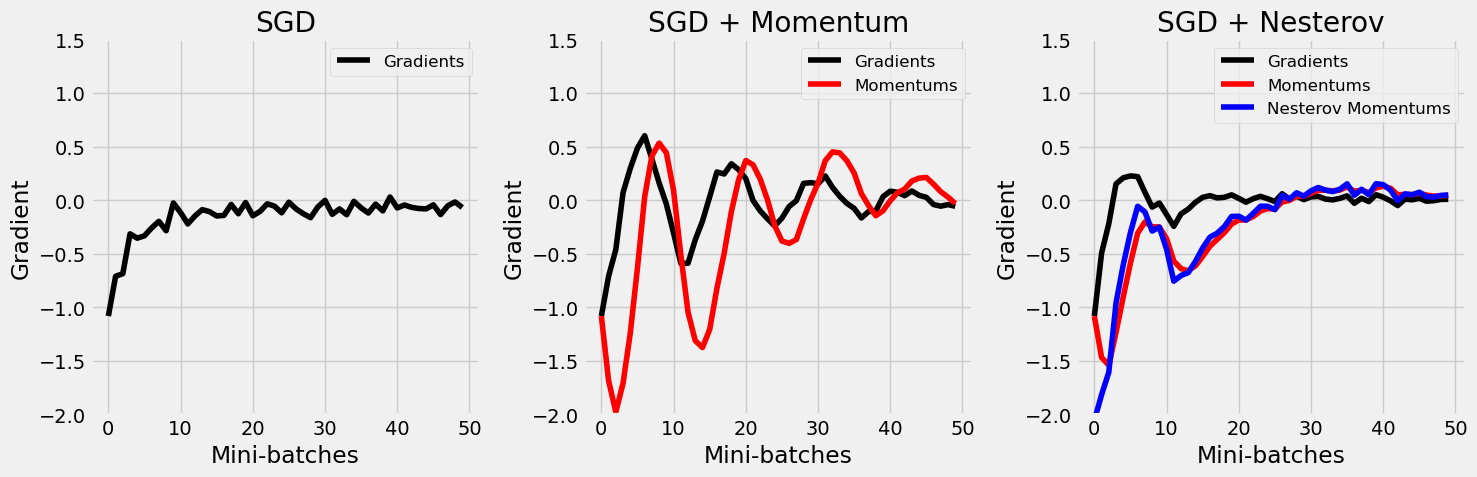

In [95]:
# Gerando um gr√°fico para representar os resultados
fig_21 = figure21(results)

# Learning Rate Schedulers

Tamb√©m √© poss√≠vel agendar as mudan√ßas na taxa de aprendizado √† medida que o treinamento avan√ßa, em vez de adaptar os gradientes. Digamos que voc√™ gostaria de reduzir a taxa de aprendizado em uma ordem de magnitude (ou seja, multiplic√°-la por 0,1) a cada T √©pocas, de modo que o treinamento seja mais r√°pido no come√ßo e desacelere ap√≥s um tempo para tentar evitar problemas de converg√™ncia.

√â isso que um agendador de taxa de aprendizado faz: Ele atualiza a taxa de aprendizado do otimizador.

Portanto, n√£o deve ser surpresa que um dos argumentos do agendador seja o pr√≥prio otimizador. A taxa de aprendizado definida para o otimizador ser√° a taxa de aprendizado inicial do agendador. Como exemplo, vamos pegar o agendador mais simples: o StepLR, que simplesmente multiplica a taxa de aprendizado por um fator gamma a cada step_size √©pocas.

No c√≥digo abaixo, criamos um otimizador fict√≠cio, que est√° "atualizando" um par√¢metro falso com uma taxa de aprendizado inicial de 0,01. O agendador fict√≠cio, uma inst√¢ncia de StepLR, multiplicar√° essa taxa de aprendizado por 0,1 a cada duas √©pocas.

In [108]:
# Definindo o otimizador SGD com par√¢metro dummy
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Definindo o agendador StepLR que modifica a taxa de aprendizado a cada 2 √©pocas
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

O agendador tem um m√©todo step() assim como o otimizador. Voc√™ deve chamar o m√©todo step() do agendador depois de chamar o m√©todo step() do otimizador.

Dentro do loop de treinamento, ficar√° assim:

In [109]:
for epoch in range(4):
    # Loop de treinamento (o c√≥digo real de treinamento deve ser adicionado aqui)
    
    # Exibe a √∫ltima taxa de aprendizado
    print(dummy_scheduler.get_last_lr())
    
    # Primeiramente, realiza a atualiza√ß√£o do otimizador
    dummy_optimizer.step()
    
    # Depois, realiza a atualiza√ß√£o do agendador
    dummy_scheduler.step()
    
    # Zera os gradientes ap√≥s a atualiza√ß√£o
    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


Como esperado, manteve a taxa de aprendizado inicial por duas √©pocas e depois a multiplicou por 0,1, resultando em uma taxa de aprendizado de 0,001 por mais duas √©pocas. Em resumo, √© assim que funciona um agendador de taxa de aprendizado.

"Todo agendador diminui a taxa de aprendizado?"

Na verdade, n√£o. Antigamente, era procedimento padr√£o diminuir a taxa de aprendizado conforme voc√™ treinava o modelo, mas essa ideia foi desafiada pelas taxas de aprendizado c√≠clicas (isso √© a parte "c√≠clica" do artigo de Leslie N. Smith!). Existem muitos tipos diferentes de agendadores, como voc√™ pode ver. E muitos deles est√£o dispon√≠veis no PyTorch.

Estamos dividindo os agendadores em tr√™s grupos: agendadores que atualizam a taxa de aprendizado a cada T √©pocas (mesmo se T=1), como no exemplo acima; o agendador que s√≥ atualiza a taxa de aprendizado quando a perda de valida√ß√£o parece estar estagnada; e agendadores que atualizam a taxa de aprendizado ap√≥s cada mini-batch.

## Epoch Schedulers

Esses agendadores ter√£o seu m√©todo step() chamado ao final de cada √©poca. Mas cada agendador tem suas pr√≥prias regras para atualizar a taxa de aprendizado.

* StepLR: Multiplica a taxa de aprendizado por um fator gamma a cada step_size √©pocas.
  
* MultiStepLR: Multiplica a taxa de aprendizado por um fator gamma nas √©pocas indicadas na lista de marcos.
  
* ExponentialLR: Multiplica a taxa de aprendizado por um fator gamma a cada √©poca, sem exce√ß√µes.
  
* LambdaLR: Recebe sua pr√≥pria fun√ß√£o personalizada que deve receber a √©poca como argumento e retornar o fator multiplicativo correspondente (em rela√ß√£o √† taxa de aprendizado inicial).
  
* CosineAnnealingLR: Usa uma t√©cnica chamada cosine annealing para atualizar a taxa de aprendizado, mas n√£o vamos entrar em detalhes aqui.

  
Podemos usar o LambdaLR para imitar o comportamento do agendador StepLR definido acima:

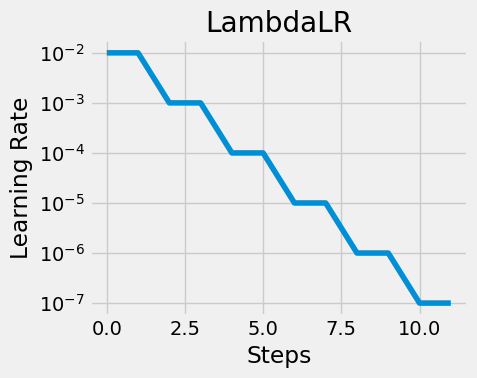

In [110]:
# Definindo o otimizador SGD
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Usando LambdaLR que ajusta a taxa de aprendizado com base na √©poca
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))

# Alternativamente, poderia ser usado um StepLR equivalente:
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

# Exibe o gr√°fico de mudan√ßas de taxa de aprendizado
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

## Validation Loss Scheduler

O agendador ReduceLROnPlateau tamb√©m deve ter seu m√©todo step() chamado ao final de cada √©poca, mas ele tem seu pr√≥prio grupo aqui porque n√£o segue um agendamento pr√©-definido. Ir√¥nico, n√©?

O m√©todo step() recebe a perda de valida√ß√£o como argumento, e o agendador pode ser configurado para tolerar a falta de melhoria na perda (at√© um limite, √© claro) por um n√∫mero espec√≠fico de √©pocas (o argumento chamado patience).

Depois que o agendador perde a paci√™ncia, ele atualiza a taxa de aprendizado, multiplicando-a pelo argumento factor (para os agendadores listados na se√ß√£o anterior, esse fator foi chamado de gamma).

Para ilustrar seu comportamento, vamos supor que a perda de valida√ß√£o permane√ßa no mesmo valor (seja l√° qual for) por 12 √©pocas consecutivas. O que nosso agendador faria?

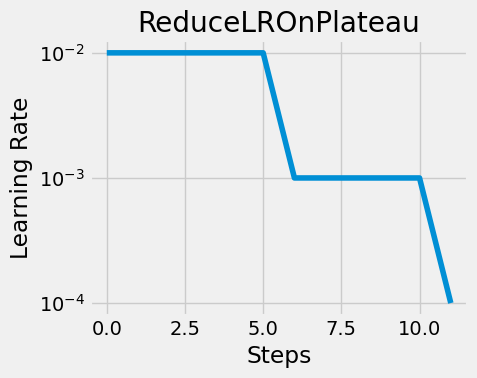

In [111]:
# Definindo o otimizador SGD
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)

# Usando ReduceLROnPlateau que reduz a taxa de aprendizado se a perda de valida√ß√£o n√£o melhorar
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

# Exibe o gr√°fico de mudan√ßas de taxa de aprendizado
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

Sua paci√™ncia √© de quatro √©pocas, ent√£o ap√≥s quatro √©pocas observando a mesma perda, ele est√° por um fio. Ent√£o vem a quinta √©poca sem mudan√ßa: "Chega, a taxa de aprendizado precisa cair" :-) Ent√£o, na sexta √©poca, o otimizador j√° est√° usando a taxa de aprendizado atualizada. Se nada mudar por mais quatro √©pocas, ela diminuir√° novamente, como mostrado na figura acima.


## Altera√ß√µes na Classe Architecture

In [112]:
# Adicionando a fun√ß√£o _epoch_schedulers √† classe Architecture
def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            # Atualiza o agendador
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            # Armazena a taxa de aprendizado atual
            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_epoch_schedulers', _epoch_schedulers)

In [113]:
def train(self, n_epochs, seed=42):
    # Garantir reprodutibilidade do processo de treinamento
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Incrementa o n√∫mero total de √©pocas
        self.total_epochs += 1

        # Realiza o treinamento usando mini-lotes
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # Valida√ß√£o (sem c√°lculo de gradientes)
        with torch.no_grad():
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # Atualiza o agendador com a perda de valida√ß√£o
        self._epoch_schedulers(val_loss)

        # Se um SummaryWriter foi configurado, registra os dados
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)

    if self.writer:
        self.writer.close()

setattr(Architecture, 'train', train)

## Mini-Batch Schedulers

Esses agendadores t√™m seu m√©todo step() chamado ao final de cada mini-batch. Todos eles s√£o agendadores c√≠clicos.


* CyclicLR: Cicla entre base_lr e max_lr (desconsiderando a taxa de aprendizado inicial definida no otimizador), usando step_size_up atualiza√ß√µes para ir de base para max taxa de aprendizado, e step_size_down atualiza√ß√µes para voltar. Esse comportamento corresponde a mode=triangular. Al√©m disso, √© poss√≠vel diminuir a amplitude usando diferentes modos: triangular2 vai reduzir pela metade a amplitude ap√≥s cada ciclo, enquanto exp_range diminuir√° exponencialmente a amplitude usando gamma como base e o n√∫mero do ciclo como expoente.
Uma escolha t√≠pica para max_lr √© a taxa de aprendizado encontrada usando o LR Range Test.


* OneCycleLR: Usa um m√©todo chamado annealing para atualizar a taxa de aprendizado de seu valor inicial at√© uma taxa de aprendizado m√°xima definida (max_lr) e depois at√© uma taxa de aprendizado muito mais baixa ao longo de um n√∫mero de atualiza√ß√µes (total_steps), realizando assim um √∫nico ciclo.

  
* CosineAnnealingWarmRestarts: Usa cosine annealing para atualizar a taxa de aprendizado, mas n√£o vamos entrar em detalhes aqui, exceto para dizer que esse agendador requer o n√∫mero da √©poca (incluindo a parte fracion√°ria correspondente ao n√∫mero de mini-batches ao longo do tamanho do data loader) como argumento de seu m√©todo step().

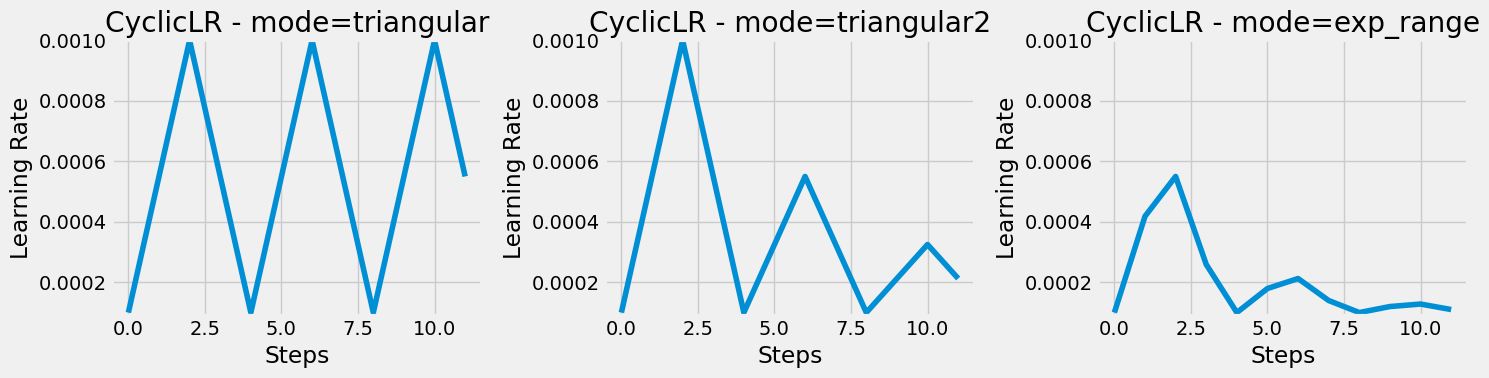

In [114]:
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

# Definindo tr√™s tipos de agendadores de ciclo
dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(0.5))

# Exibe os gr√°ficos de mudan√ßa de taxa de aprendizado
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

In [115]:
# Fun√ß√£o que aplica agendadores para mini-batches
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            # Atualiza o agendador a cada mini-lote
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            # Armazena a taxa de aprendizado atual
            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_mini_batch_schedulers', _mini_batch_schedulers)

In [116]:
# Fun√ß√£o que realiza o processamento dos mini-lotes
def _mini_batch(self, validation=False):
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(Architecture, '_mini_batch', _mini_batch)

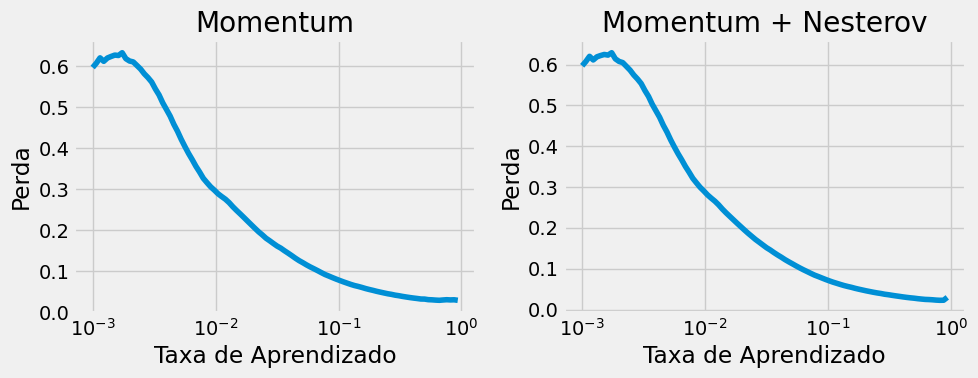

In [117]:
# Exemplo de visualiza√ß√£o da taxa de aprendizado durante o treinamento
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = Architecture(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)
    
    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [128]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [129]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

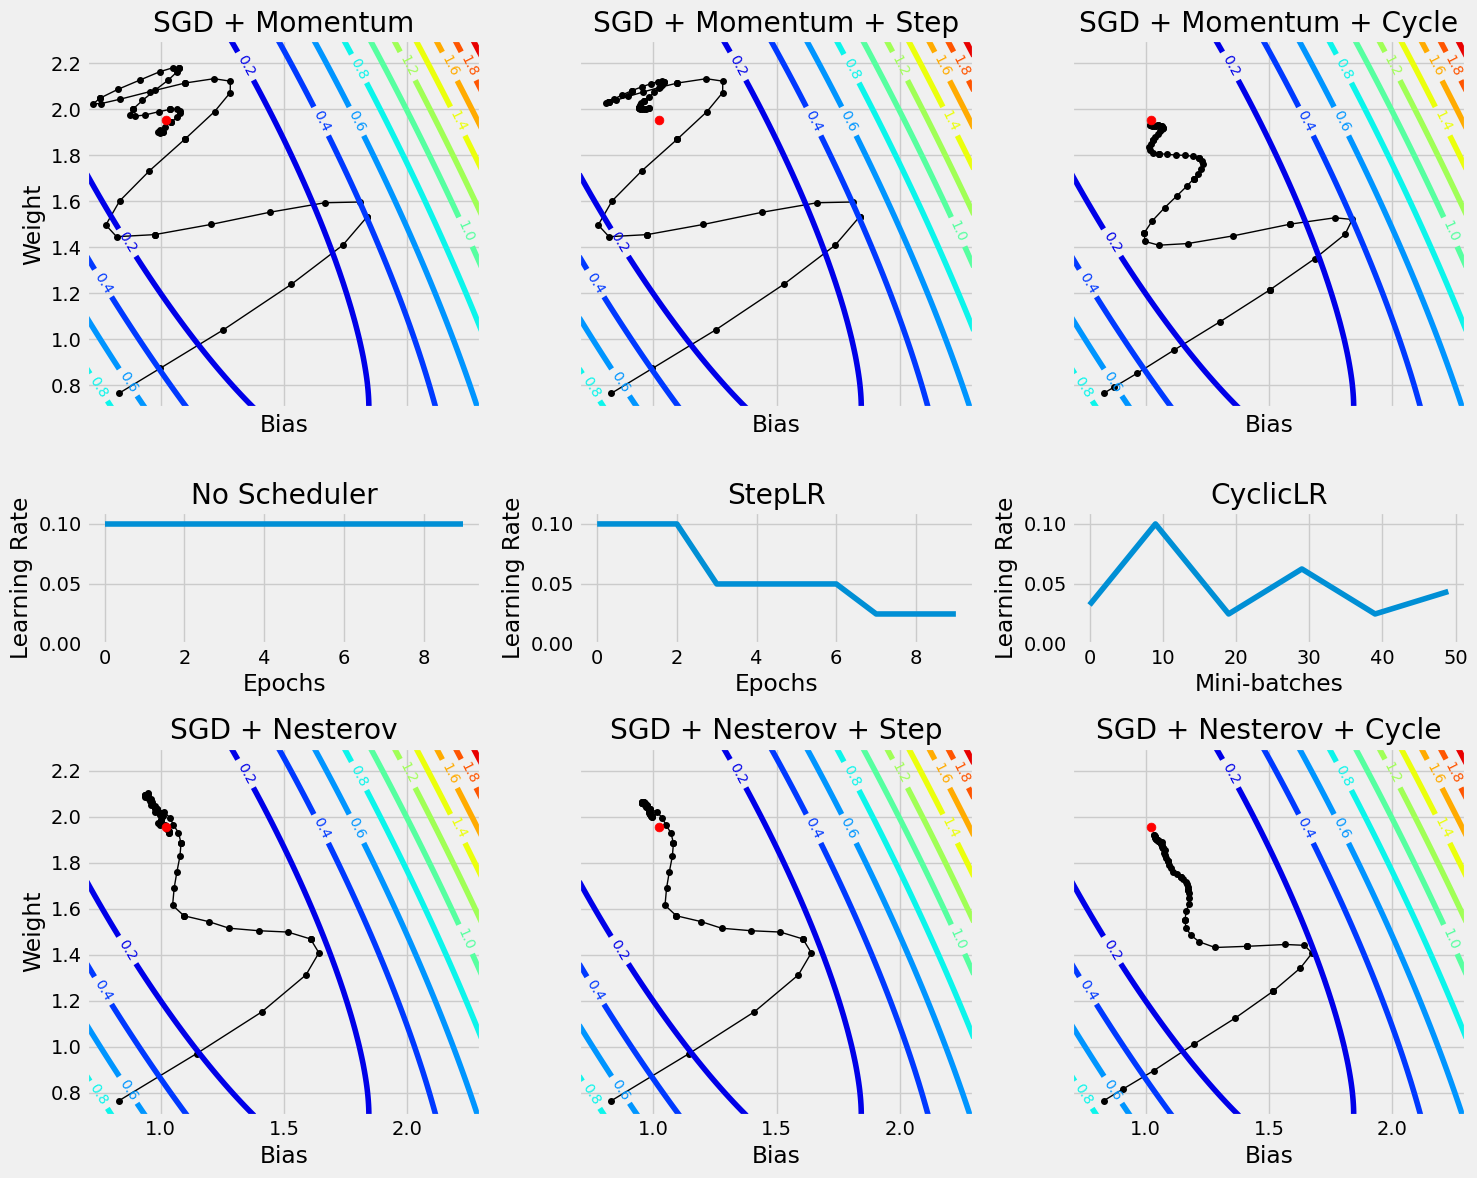

In [130]:
fig = figure28(results, b, w, bs, ws, all_losses)

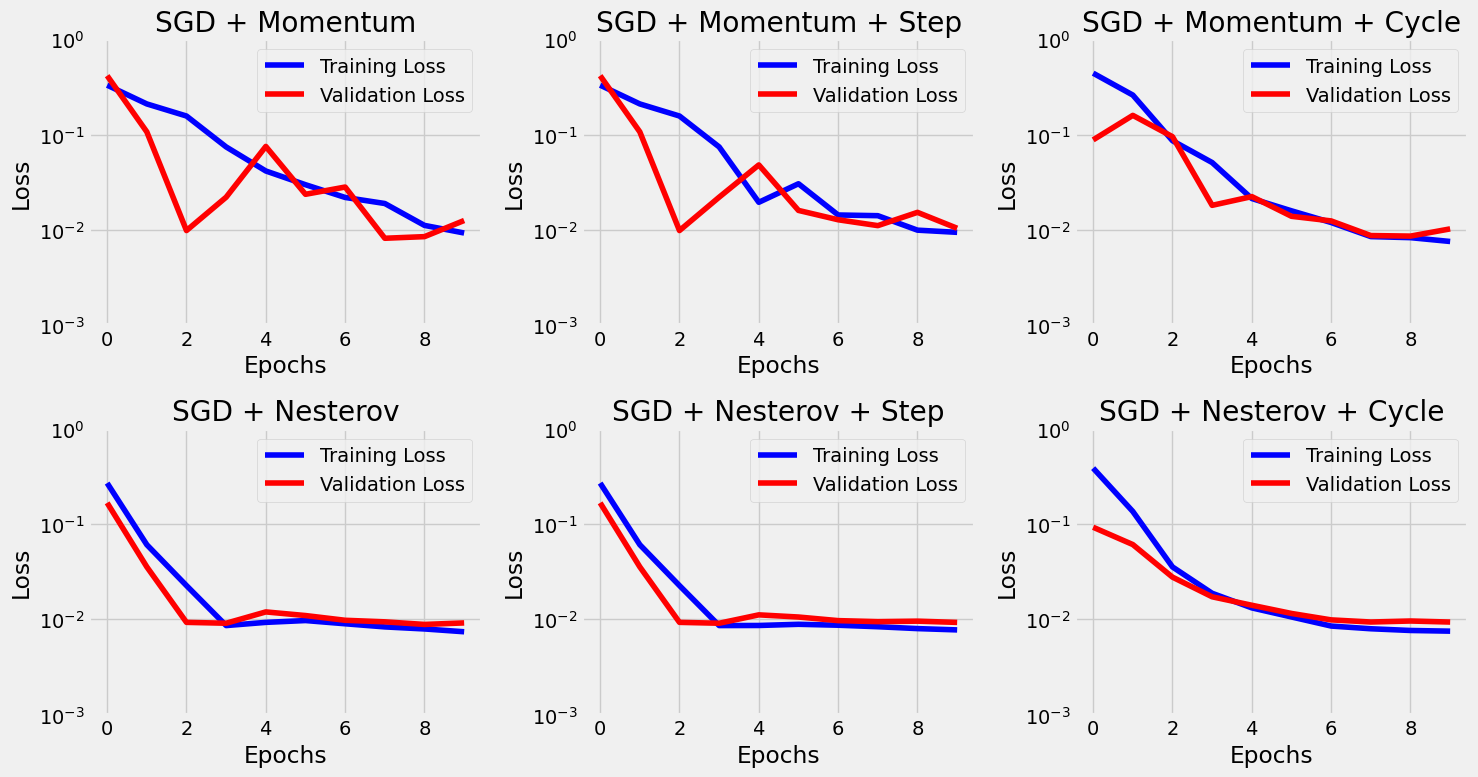

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

# Hora da pr√°tica

Vamos integrar todos os conceitos que vimos: EWMA, adam, SDG e learning rate schedulers.


O primeiro passo √© escolher nosso dataset. Se queremos um exemplo de CNN simples, nada melhor do que usar o MNIST, um dos datasets mais usados para exemplos de vis√£o computacional.


O MNIST √© um grande conjunto de dados (treinamento com 60.000 exemplos e um conjunto de teste com 10.000 exemplos) de d√≠gitos manuscritos. Os d√≠gitos foram normalizados em termos de tamanho e centralizados em uma imagem de tamanho fixo.

Vamos utilizar o DataLoader e uma normaliza√ß√£o baseada em estat√≠sticas do dataset:

In [122]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

O nosso pr√≥ximo passo √© a inicializa√ß√£o do nosso modelo. Como o foco desta se√ß√£o √© mostra o uso das ferramentas, vamos aplicar uma arquitetura bem simples.

In [123]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

Agora vamos para o que interessa! Vamos definir o Adam e o SGD para compara√ß√£o e incluir um scheduler da nossa escolha (aqui d√° para brincar e testar todos que estudamos).

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

N√£o podemos esquecer da suaviza√ß√£o dos gradientes com EWMA.


In [125]:
def ewma(values, alpha=0.2):
    result = []
    avg = values[0]
    for val in values:
        avg = alpha * val + (1 - alpha) * avg
        result.append(avg)
    return result

Agora vamos treinar nosso modelo e obter nossas acur√°cias para cada √©poca.

In [126]:
num_epochs = 20
train_loss = []
train_acc = []
lrs = []
gradients = []

In [127]:
for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        gradients.append(grad_norm)

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()
    train_loss.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)
    lrs.append(optimizer.param_groups[0]['lr'])

Bom, com isso j√° temos um modelo ‚Äî mesmo que simples ‚Äî em pleno funcionamento! Vamos ver como ele ele foi na pr√°tica?

Primeiro, vamos ver nossa curva de acur√°cia!

Text(0.5, 1.0, 'Acur√°cia (%)')

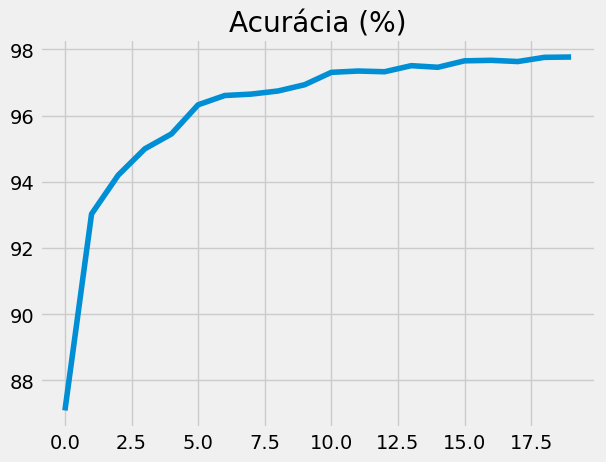

In [128]:
plt.plot(train_acc, label='Train Accuracy')
plt.title('Acur√°cia (%)')

Para um modelo simples, os resultados foram bem bacanas! 97,42% de acur√°cia no treinamento :)

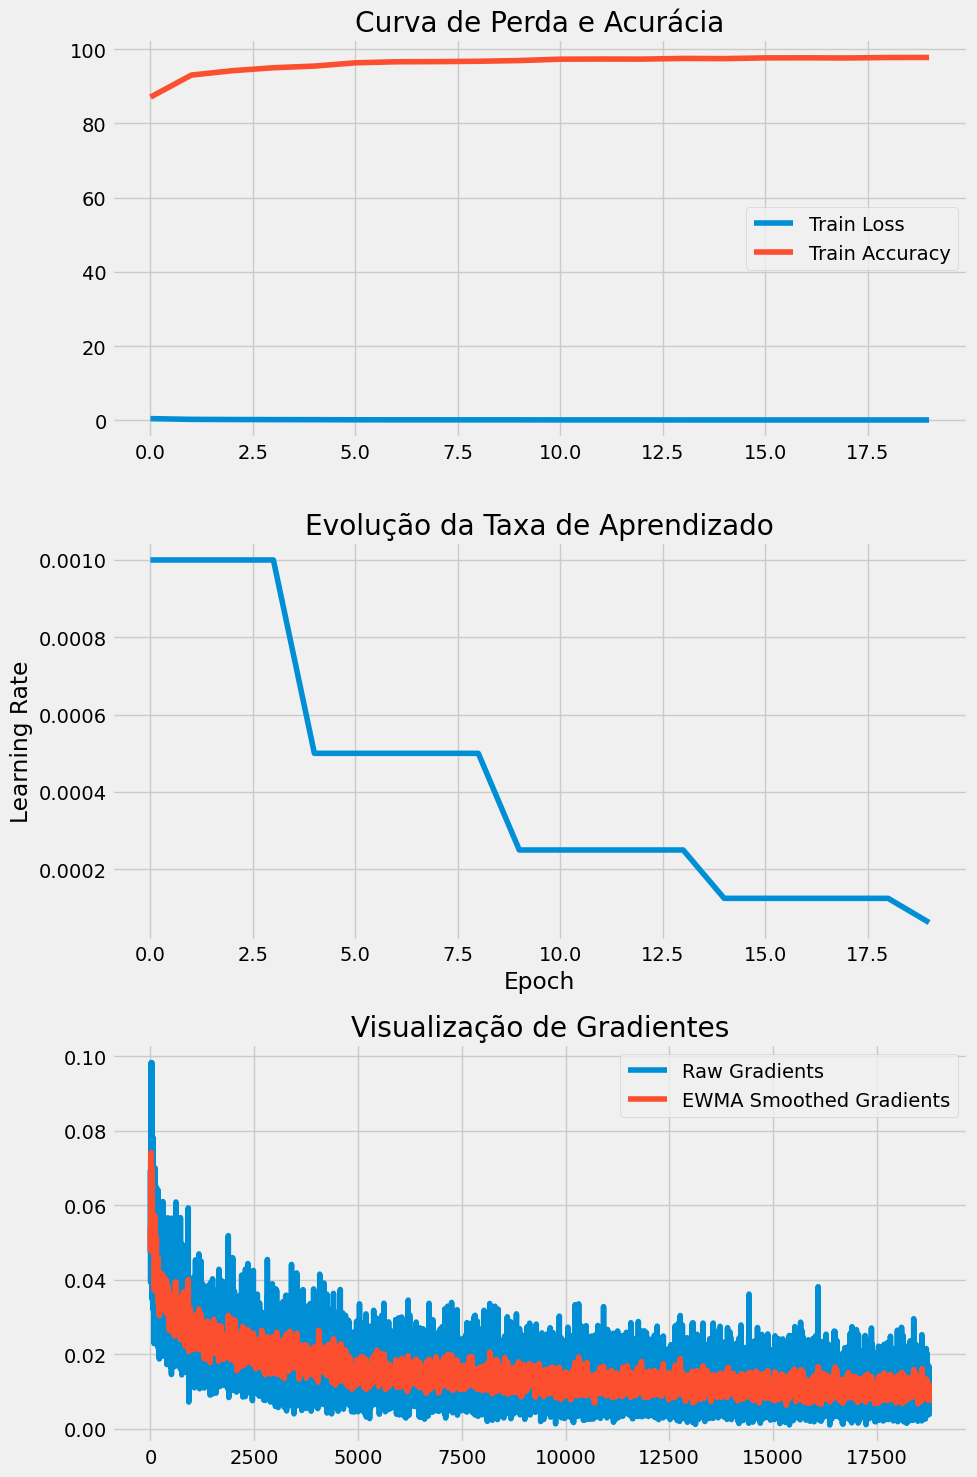

In [129]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))


axs[0].plot(train_loss, label='Train Loss')
axs[0].plot(train_acc, label='Train Accuracy')
axs[0].set_title('Curva de Perda e Acur√°cia')
axs[0].legend()

axs[1].plot(lrs)
axs[1].set_title('Evolu√ß√£o da Taxa de Aprendizado')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Learning Rate')

smoothed_gradients = ewma(gradients)
axs[2].plot(gradients, label='Raw Gradients')
axs[2].plot(smoothed_gradients, label='EWMA Smoothed Gradients')
axs[2].set_title('Visualiza√ß√£o de Gradientes')
axs[2].legend()

plt.tight_layout()
plt.show()

A gente consegue ver que a taxa de aprendizado come√ßa relativamente alta e decresce em etapas ao longo das √©pocas. Isso se deve ao scheduler escolhido, que reduz a taxa de aprendizado progressivamente, o que pode ajudar o modelo a refinar os pesos ao longo do treinamento, prevenindo oscila√ß√µes excessivas no final. Podemos testar outros tipos de schedulers para comparar seu comportamento. Legal, n√©?


Inicialmente, os gradientes s√£o elevados, mas reduzem com o tempo, indicando que o modelo est√° se ajustando e atualizando os pesos de forma mais sutil ao longo do tempo. A curva suavizada mostra uma diminui√ß√£o mais est√°vel dos gradientes, o que sugere um processo de converg√™ncia controlado, do jeito que a gente queria ü•≥ü™©.
